In [2]:
import os
import sys

import scipy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import warnings

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%aimport
warnings.filterwarnings('ignore')
os.environ['MOMAPS_HOME'] = '/home/labs/hornsteinlab/Collaboration/MOmaps_Noam/MOmaps'
sys.path.insert(1, os.getenv('MOMAPS_HOME'))
import k_means_constrained
from src.common.configs.base_config import BaseConfig

Modules to reload:
all-except-skipped

Modules to skip:



In [3]:
# embeddings_data_config:
# class EmbeddingsALLDatasetConfig(DatasetConfig):
#     def __init__(self):
#         super().__init__()

#         self.INPUT_FOLDERS = [os.path.join(self.PROCESSED_FOLDER_ROOT, "spd2", "SpinningDisk", f) for f in 
#                         [f"batch{i}" for i in [3,4,5,6,7,8,9]]]
        
#         self.SPLIT_DATA = False
#         self.EXPERIMENT_TYPE = 'neurons'
#         self.ADD_REP_TO_LABEL = True
#         self.ADD_BATCH_TO_LABEL = True
#         self.EMBEDDINGS_LAYER = 'vqvec2'
#         self.CELL_LINES = ['WT'] 
#         self.TRAIN_BATCHES = ['batch7','batch8']
#         self.MARKERS_TO_EXCLUDE = ['DAPI','TIA1','FMRP']
#         self.REPS = ['rep1', 'rep2'] # Can be : ['rep1', 'rep2'] or ['rep1'] or ['rep2']

In [4]:
dists = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/models_outputs_batch78_nods_tl_ep23/distances/neurons/vqvec2/between_cell_lines_conds_similarities_rep_new.csv")
dists_cellpro = pd.read_csv("/home/labs/hornsteinlab/Collaboration/MOmaps/outputs/cell_profiler/between_cell_lines_conds_similarities_rep_CellProfiler.csv")

In [5]:
marker_to_organelle = BaseConfig().UMAP_MAPPINGS_MARKERS
cell_line_dict = BaseConfig().UMAP_MAPPINGS_ALS

In [6]:
dists['organelle'] = dists['marker'].map(lambda x: marker_to_organelle.get(x, {}).get('alias'))
dists_cellpro['organelle'] = dists_cellpro['marker'].map(lambda x: marker_to_organelle.get(x, {}).get('alias'))

In [7]:
dists_wt = dists[dists.cell_line_condition == 'WT_Untreated'][['marker','batch','rep','WT_stress','organelle']].sort_values(by='marker')
dists_wt = dists_wt[~dists_wt.marker.str.contains('TIA1|FMRP')] # remove unwanted markers

# min max scale for each group of batch-rep distances:
for name, group in dists_wt.groupby(['batch','rep'])['WT_stress']:
    group_min = group.min()
    group_max = group.max()
    scaled_group = (group-group_min) / (group_max - group_min)
    dists_wt.loc[group.index, 'WT_stress_scaled'] = scaled_group

dists_wt.rename(columns={'marker':"Marker"}, inplace=True)
dists_wt['batch_rep'] = dists_wt['batch'] + '_' + dists_wt['rep']
dists_wt['z_score'] = None

# same for cellProfiler distances
dists_cellpro = dists_cellpro[dists_cellpro.cell_line_condition == 'WT_Untreated'][['marker','batch','rep','WT_stress','organelle']].sort_values(by='marker')
dists_cellpro = dists_cellpro[~dists_cellpro.marker.str.contains('TIA1|FMRP')]
for name, group in dists_cellpro.groupby(['batch','rep'])['WT_stress']:
    group_min = group.min()
    group_max = group.max()
    scaled_group = (group-group_min) / (group_max - group_min)
    dists_cellpro.loc[group.index, 'WT_stress_scaled'] = scaled_group
dists_cellpro.rename(columns={'marker':"Marker"}, inplace=True)

In [8]:
# # heatmap of dists per batch-rep and marker
# pivot_df = dists.pivot(index='Marker', columns='batch_rep', values='WT_stress')
# sns.heatmap(pivot_df)
# plt.show()

In [9]:
# add bio rep column
dists_wt['Biological Replicate'] = np.where(dists_wt.batch_rep.str.contains(r'(3|4|5)', regex=True),
                                         'Replicate 1', 
                                         'Replicate 2')
dists_6_9 = dists_wt[dists_wt['Biological Replicate'] =='Replicate 2']

order = dists_wt.groupby("organelle")['WT_stress_scaled'].mean().sort_values(ascending=False).index
order_6_9 = dists_6_9.groupby("organelle")['WT_stress_scaled'].mean().sort_values(ascending=False).index

order_cellpro = dists_cellpro.groupby("organelle")['WT_stress_scaled'].mean().sort_values(ascending=False).index

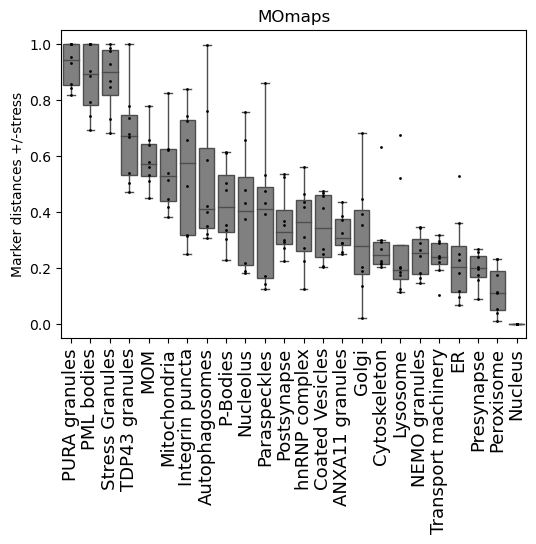

In [10]:
# fig 3B
fig, ax = plt.subplots(figsize=(6,4))
sns.stripplot(data=dists_6_9, x='organelle', y='WT_stress_scaled', color='black',
              dodge=True, order=order_6_9,size=2, jitter=0, marker='o', ax=ax, edgecolor='k',legend=False)
sns.boxplot(data=dists_6_9,x='organelle',y='WT_stress_scaled' ,ax=ax,fliersize=0,
               order=order_6_9,linewidth=1, color='gray') 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.set_ylabel('Marker distances +/-stress')
ax.set_xlabel('')
ax.set_title('MOmaps')
# plt.show()
plt.savefig('manuscript/fig3/panelB/distances.eps',dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


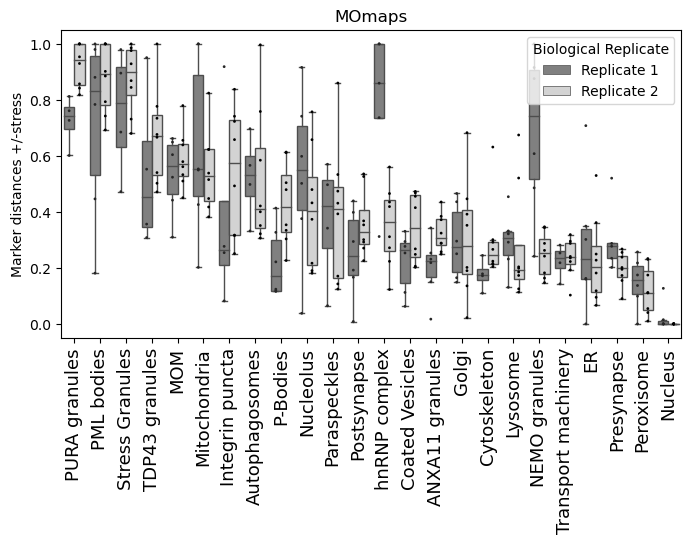

In [11]:
# sup 5B
fig, ax = plt.subplots(figsize=(8,4))
hue_palette = {'Replicate 1': 'gray', 'Replicate 2': 'lightgray'}
sns.stripplot(data=dists_wt, x='organelle', y='WT_stress_scaled', hue='Biological Replicate', color='black',
              dodge=True, order=order_6_9,size=2, jitter=0, marker='o', ax=ax, edgecolor='k',legend=False)
sns.boxplot(data=dists_wt,x='organelle',y='WT_stress_scaled', hue='Biological Replicate' ,ax=ax,fliersize=0,
               order=order_6_9,linewidth=1, palette=hue_palette) 
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.set_ylabel('Marker distances +/-stress')
ax.set_xlabel('')
ax.set_title('MOmaps')
# plt.show()
plt.savefig('manuscript/sup_fig5/panelB/distances.eps',dpi=300, bbox_inches='tight')

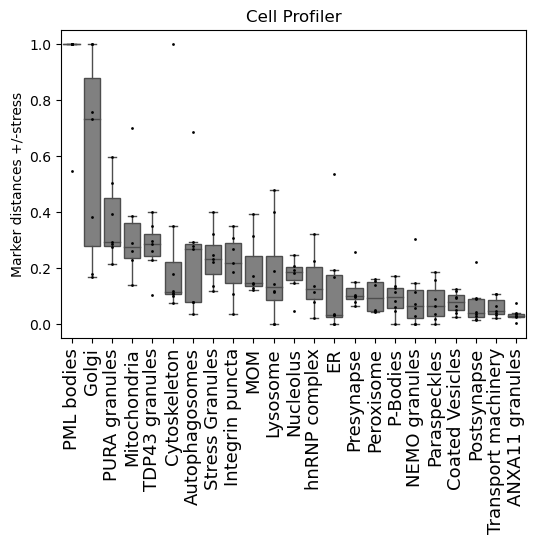

In [12]:
# fig 3C or supp
fig, ax = plt.subplots(figsize=(6,4))
sns.stripplot(data=dists_cellpro, x='organelle', y='WT_stress_scaled', color='black',
              dodge=True, order=order_cellpro,size=2, jitter=0, marker='o', ax=ax, edgecolor='k',legend=False)
sns.boxplot(data=dists_cellpro,x='organelle',y='WT_stress_scaled' ,ax=ax, 
               order=order_cellpro,linewidth=1,color='gray',fliersize=0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=13)
ax.set_ylabel('Marker distances +/-stress')
ax.set_xlabel('')
ax.set_title('Cell Profiler')
# plt.show()
plt.savefig('manuscript/fig3/panelC/distances_cellprofiler.eps',dpi=300, bbox_inches='tight')

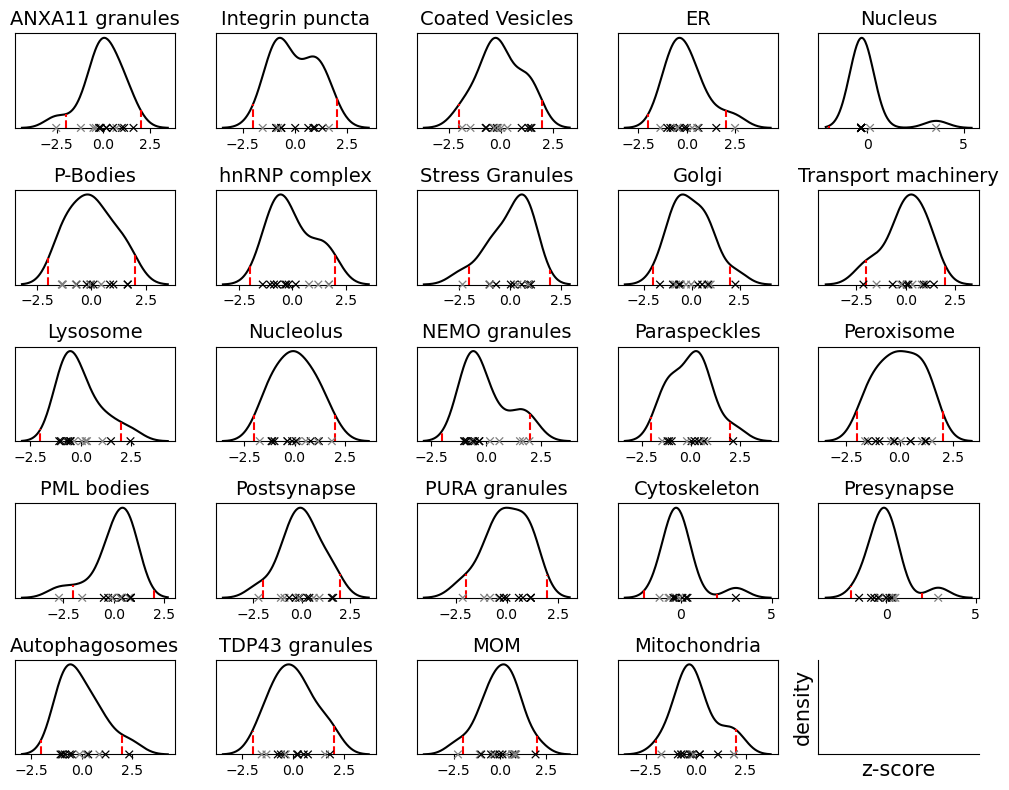

In [13]:
# normalization plots
nrows=5
ncols=5
fig, axs = plt.subplots(nrows,ncols, figsize=(10,8))
for i, (marker,marker_group) in enumerate(dists_wt.groupby('Marker')):
    mean = np.mean(marker_group['WT_stress_scaled'])
    std_dev = np.std(marker_group['WT_stress_scaled'])
    z_scores = (marker_group['WT_stress_scaled'] - mean) / std_dev
    dists_wt.loc[dists_wt['Marker'] == marker, 'z_score'] = z_scores


    to_plot = dists_wt[dists_wt['Marker'] == marker][['z_score','batch_rep']]
    to_plot.sort_values(by='z_score')
    to_plot['color'] = np.where(to_plot.batch_rep.str.contains(r'3|4|5', regex=True),'gray','black')    

    ax = axs[i//ncols,i%ncols]

    # Set a constant y value (e.g., 0)
    y_values = [0] * len(to_plot)
    # add z scores points to the graph
    ax.scatter(to_plot.z_score, y_values, color=to_plot.color,
                          marker='x', zorder=10, clip_on=False, s=30, linewidths=0.9)
    ax.set_yticklabels([])
    ax.set_yticks([])
    kde = sns.kdeplot(to_plot.z_score, shade=False, color='black', label="Density", ax = ax)

    # Calculate the standard deviations from the mean
    std_deviation_values = [-2,2]  # Adjust this as needed
    for std_dev_value in std_deviation_values:
        std_dev_value = np.nanmean(to_plot.z_score) + std_dev_value * np.nanstd(to_plot.z_score)
        y_limit =kde.get_lines()[0].get_ydata()[np.abs(kde.get_lines()[0].get_xdata() -  std_dev_value).argmin()]
        ax.vlines(std_dev_value, ymin=0, ymax=y_limit, colors='r', linestyles='--')
        # print(marker)


    # Add labels and legend
    ax.set_xlabel("")
    title = marker_to_organelle[marker]['alias']
    ax.set_title(title, fontsize=14)    
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    # legend_elements = [Line2D([0], [0], marker = 'x', color='black',linestyle='', label='Biological rep 2'),
    #                    Line2D([0], [0], marker='x', color='gray', linestyle='', label='Biological rep 1')]

    # ax.legend(handles=legend_elements, prop={'size': 6}, loc='upper right')
axs[-1,-1].set_xlabel("z-score", fontsize=15)
axs[-1,-1].set_ylabel("density",fontsize=15)
# axs[-1,-1].set_xticklabels([])
# axs[-1,-1].set_yticklabels([])
axs[-1,-1].set_xticks([])
axs[-1,-1].set_yticks([])
axs[-1,-1].spines['top'].set_visible(False)
axs[-1,-1].spines['right'].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig('manuscript/sup_fig5/panelC/density_plots.eps',dpi=300, bbox_inches='tight')

## density plots for als distances

In [14]:
als = ['FUSHomozygous_Untreated','TDP43_Untreated','TBK1_Untreated','FUSRevertant_Untreated','OPTN_Untreated','FUSHeterozygous_Untreated']
dists_als = dists[dists.cell_line_condition.str.contains('|'.join(als), regex=True)][['marker','batch','rep','organelle','WT_Untreated','cell_line_condition']].sort_values(by='marker')
dists_als = dists_als[~dists_als.marker.str.contains('TIA1|FMRP')] # remove unwanted markers
dists_als = dists_als[dists_als.batch.str.contains('6|7|8|9', regex=True)]
# min max scale for each group of batch-rep distances:
for name, group in dists_als.groupby(['batch','rep','cell_line_condition'])['WT_Untreated']:
    group_min = group.min()
    group_max = group.max()
    scaled_group = (group-group_min) / (group_max - group_min)
    dists_als.loc[group.index, 'WT_Untreated_sacled'] = scaled_group
    
dists_als.rename(columns={'marker':"Marker"}, inplace=True)
# dists_wt['batch_rep'] = dists_wt['batch'] + '_' + dists_wt['rep']
dists_als['z_score'] = None

in marker DAPI, cell_line TDP43_Untreated, the distance value is constant (0.0)
in marker FUS, cell_line FUSHeterozygous_Untreated, the distance value is constant (1.0)
in marker FUS, cell_line FUSHomozygous_Untreated, the distance value is constant (1.0)


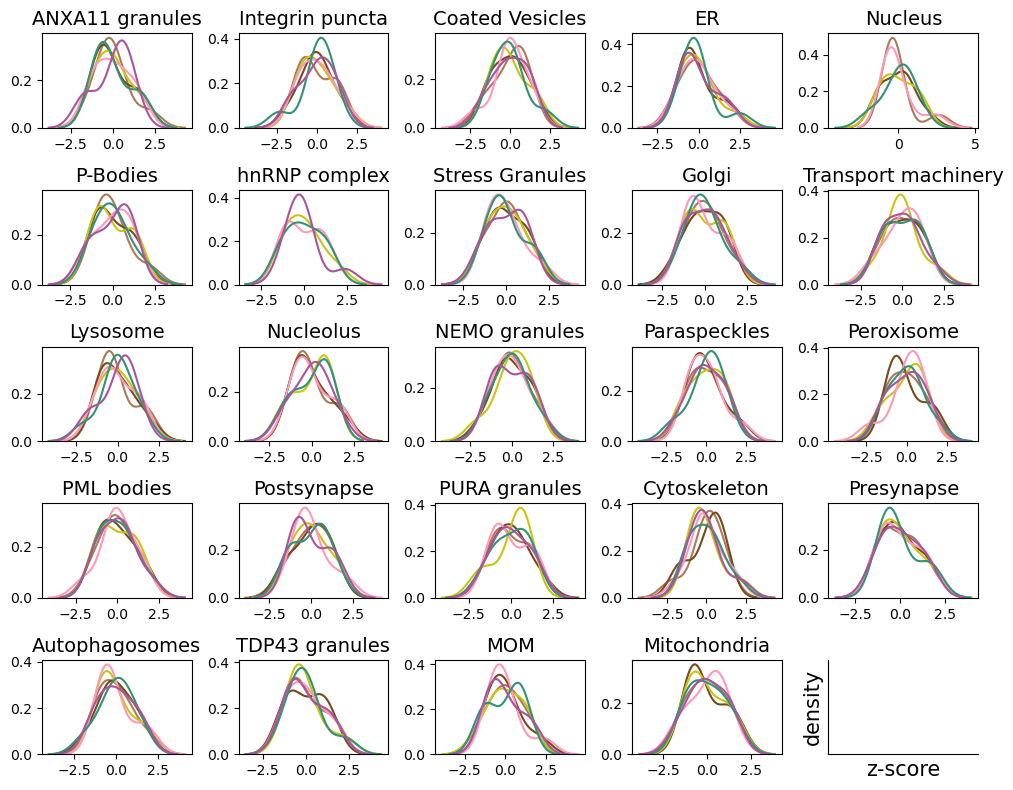

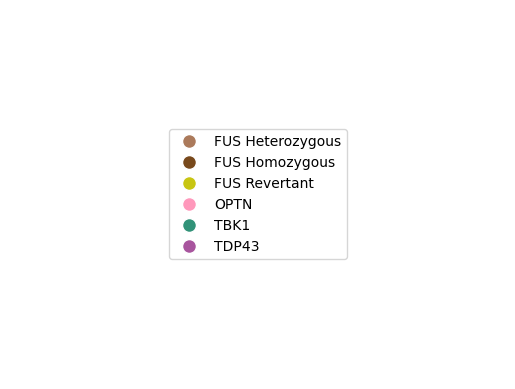

In [99]:
# normalization plots
nrows=5
ncols=5
fig, axs = plt.subplots(nrows,ncols, figsize=(10,8))
for i, (marker,marker_group) in enumerate(dists_als.groupby('Marker')):
    ax = axs[i//ncols,i%ncols]

    for cell_line_condition, cell_line_condition_group in marker_group.groupby('cell_line_condition'):

        mean = np.mean(cell_line_condition_group['WT_Untreated_sacled'])
        std_dev = np.std(cell_line_condition_group['WT_Untreated_sacled'])
        if std_dev == 0:
            print(f'in marker {marker}, cell_line {cell_line_condition}, the distance value is constant ({mean})')
        z_scores = (cell_line_condition_group['WT_Untreated_sacled'] - mean) / std_dev    

        kde = sns.kdeplot(z_scores, shade=False, label=cell_line_condition, ax = ax, color = cell_line_dict[cell_line_condition]['color'])
    ax.set_xlabel("")
    ax.set_ylabel("")

    # Add labels and legend
    
    title = marker_to_organelle[marker]['alias']
    ax.set_title(title, fontsize=14)   
    # ax.set_yticklabels([])
    # ax.set_yticks([])
    
axs[-1,-1].set_xlabel("z-score", fontsize=15)
axs[-1,-1].set_ylabel("density",fontsize=15)
axs[-1,-1].set_xticks([])
axs[-1,-1].set_yticks([])
axs[-1,-1].spines['top'].set_visible(False)
axs[-1,-1].spines['right'].set_visible(False)
plt.tight_layout()
# plt.show()
plt.savefig('manuscript/sup_fig7/density_plots_als.eps',dpi=300, bbox_inches='tight')

#save also the legend
cell_lines = list(np.unique(dists_als.cell_line_condition))
cell_lines_names = [cell_line_dict[cell_line]['alias'] for cell_line in cell_lines]
colors = [cell_line_dict[cell_line]['color'] for cell_line in cell_lines]
# Create an empty plot
fig, ax = plt.subplots()

# Create legend entries without actual plot
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

# Add a legend
legend = ax.legend(handles=handles, labels=cell_lines_names, loc='center')

# Hide the axes
ax.axis('off')

# Show the legend
# plt.show()
plt.savefig('manuscript/sup_fig7/density_plots_als_legend.eps',dpi=300, bbox_inches='tight')
